In [76]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import pickle
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [77]:
with open('dataset/train.p', 'rb') as f:
    train_data = pickle.load(f)
with open('dataset/valid.p', 'rb') as f:
    val_data = pickle.load(f)
with open('dataset/test.p', 'rb') as f:
    test_data = pickle.load(f)

In [128]:
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

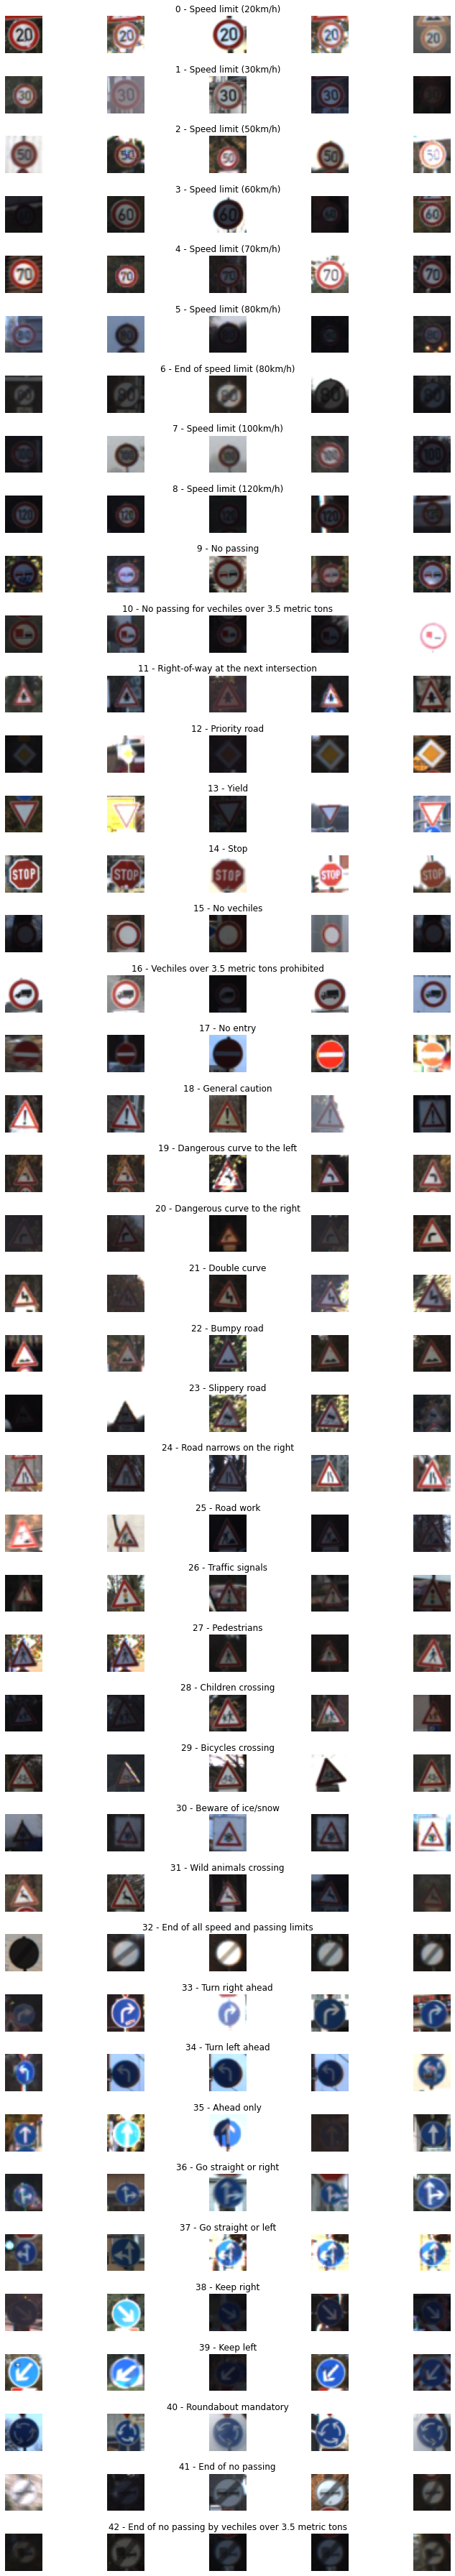

In [129]:
data = pd.read_csv('dataset/signnames.csv')
  
num_of_samples=[]

fig, axes = plt.subplots(nrows=43, ncols=5, figsize=(10,50))
fig.tight_layout()

for i in range(5):
  for j, row in data.iterrows():
    x_selected = X_train[y_train == j]
    axes[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
    axes[j][i].axis("off")
    if i == 2:
      axes[j][i].set_title(str(j) + " - " + row["SignName"])
      num_of_samples.append(len(x_selected))
plt.show()

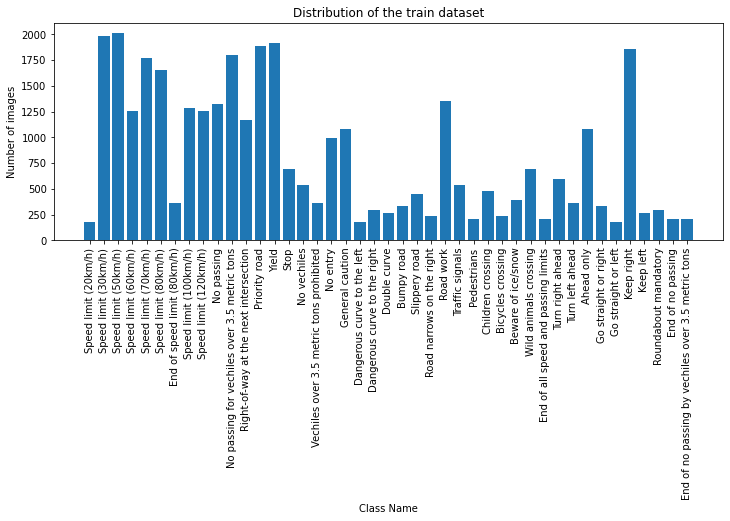

In [79]:
plt.figure(figsize=(12, 4))
plt.bar(data["SignName"], num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class Name")
plt.ylabel("Number of images")
plt.xticks(rotation=90)
plt.show()

In [97]:
def preprocess(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = cv2.equalizeHist(img)
  img = img/255
  return img

X_train = np.array(list(map(preprocess, X_train)))
X_test = np.array(list(map(preprocess, X_test)))
X_val = np.array(list(map(preprocess, X_val)))

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(34799, 32, 32)
(12630, 32, 32)
(4410, 32, 32)


In [98]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)

In [99]:
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

In [100]:
def modified_model():
  model = Sequential()
  model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
  model.add(Conv2D(60, (5, 5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(43, activation='softmax'))
  
  model.compile(Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

model = modified_model()
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 28, 28, 60)        1560      
                                                                 
 conv2d_21 (Conv2D)          (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 12, 12, 60)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 10, 10, 30)        16230     
                                                                 
 conv2d_23 (Conv2D)          (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 4, 4, 30)         0         
 g2D)                                                 

In [101]:
history = model.fit(X_train,y_train,epochs=10,validation_data=(X_val, y_val),verbose=1,batch_size=400, shuffle = 1)

Epoch 1/10
87/87 [==============================] - 5s 53ms/step - loss: 2.2045 - accuracy: 0.4051 - val_loss: 0.6616 - val_accuracy: 0.8054
Epoch 2/10
87/87 [==============================] - 4s 50ms/step - loss: 0.4599 - accuracy: 0.8603 - val_loss: 0.2578 - val_accuracy: 0.9188
Epoch 3/10
87/87 [==============================] - 4s 50ms/step - loss: 0.2141 - accuracy: 0.9336 - val_loss: 0.1933 - val_accuracy: 0.9397
Epoch 4/10
87/87 [==============================] - 4s 50ms/step - loss: 0.1348 - accuracy: 0.9590 - val_loss: 0.1693 - val_accuracy: 0.9508
Epoch 5/10
87/87 [==============================] - 5s 52ms/step - loss: 0.0973 - accuracy: 0.9702 - val_loss: 0.1615 - val_accuracy: 0.9501
Epoch 6/10
87/87 [==============================] - 4s 49ms/step - loss: 0.0736 - accuracy: 0.9770 - val_loss: 0.1342 - val_accuracy: 0.9565
Epoch 7/10
87/87 [==============================] - 4s 48ms/step - loss: 0.0623 - accuracy: 0.9792 - val_loss: 0.1191 - val_accuracy: 0.9671
Epoch 8/10
87

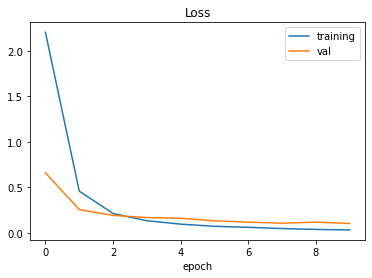

In [102]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','val'])
plt.title('Loss')
plt.xlabel('epoch')
plt.show()

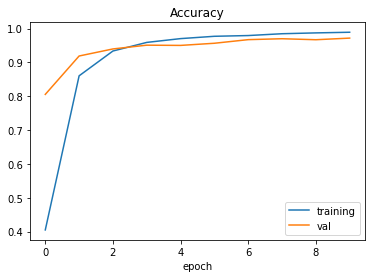

In [103]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','val'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.show()

In [104]:
score = model.evaluate(X_test, y_test, verbose=0)

print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.2231215238571167
Test accuracy: 0.9435471296310425


Predicted sign: Speed limit (30km/h)


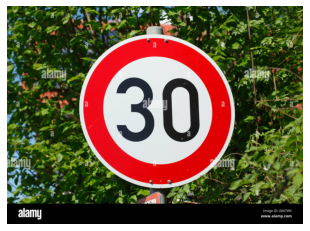

In [135]:
a=cv2.imread('road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg')
a=cv2.cvtColor(a, cv2.COLOR_BGR2RGB )
plt.imshow(a)
plt.axis("off")
a=cv2.resize(a,(32,32))
a=preprocess(a)
a=a.reshape(1, 32, 32, 1)
print("Predicted sign: "+ str(data.iloc[int(np.argmax(model.predict(a), axis=-1))].SignName))


Predicted sign: Stop


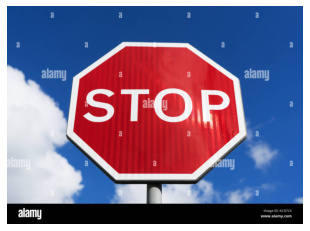

In [138]:
a=cv2.imread('stop-sign-blue-sky-background-street-signs-KCG7C4.jpg')
a=cv2.cvtColor(a, cv2.COLOR_BGR2RGB )
plt.imshow(a)
plt.axis("off")
a=cv2.resize(a,(32,32))
a=preprocess(a)
a=a.reshape(1, 32, 32, 1)
print("Predicted sign: "+ str(data.iloc[int(np.argmax(model.predict(a), axis=-1))].SignName))

Predicted sign: Road work


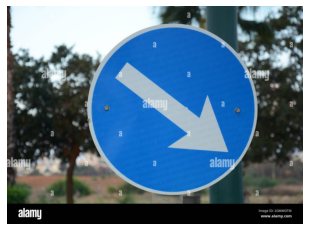

In [144]:
a=cv2.imread('pass-designated-place-on-right-blue-road-sign-pass-on-this-side-with-white-arrow-pointing-to-the-right-mandatory-signs-road-signs-in-israel-2GMMDTM.jpg')
a=cv2.cvtColor(a, cv2.COLOR_BGR2RGB )
plt.imshow(a)
plt.axis("off")
a=cv2.resize(a,(32,32))
a=preprocess(a)
a=a.reshape(1, 32, 32, 1)
print("Predicted sign: "+ str(data.iloc[int(np.argmax(model.predict(a), axis=-1))].SignName))